# 1-month_Prediction_acid

```
RM01/0006     503
RM01/0007     573
RM01/0004     672
RM01/0001    1507

Earliest data of Amonia: 2014-12-01
```

In [13]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import preprocessor as pre
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Import external drivers data
# Create rows and encoding
# To calculate the monthly average prices of target variable
# Create 12*N features, external factor prices from one-month before to 12-month before
# Combine features with target variables

gas_df = pre.get_Fred_data('PNGASEUUSDM',2015,2023)
wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2015,2023)
ammonia_df = pre.get_Fred_data('WPU0652013A',2015,2023)

price_evo_df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2016,2023)

dummy_df = pre.get_dummies_and_average_price(price_evo_df,'acid',\
                                         'RM01/0001','RM01/0004','RM01/0006','RM01/0007')

acid_df = pre.generate_features(1,12,dummy_df,\
                                PNGASEUUSDM=gas_df,\
                                PWHEAMTUSDM=wheat_df,\
                                WPU0652013A=ammonia_df
                               )

print(acid_df[(acid_df['Year'] == 2016) & (acid_df['Month'] == 1)][['Average_price','RM01/0004','RM01/0006','RM01/0007']])

     Average_price  RM01/0004  RM01/0006  RM01/0007
0         0.528015          0          0          0
167       0.846000          0          1          0
260       0.404800          1          0          0


In [16]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Create X, y
feature_list = acid_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = acid_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [17]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")

Best alpha parameter: 0.004668322274091364
Best R-squared score: 0.909
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.054
RM01/0006: 0.285
RM01/0007: -0.687
PNGASEUUSDM_1: 0.069
PWHEAMTUSDM_1: 0.068
WPU0652013A_1: 0.054
PNGASEUUSDM_2: 0.039
PWHEAMTUSDM_2: 0.0
WPU0652013A_2: 0.0
PNGASEUUSDM_3: 0.198
PWHEAMTUSDM_3: 0.201
WPU0652013A_3: 0.0
PNGASEUUSDM_4: 0.0
PWHEAMTUSDM_4: 0.028
WPU0652013A_4: -0.0
PNGASEUUSDM_5: 0.043
PWHEAMTUSDM_5: 0.0
WPU0652013A_5: -0.0
PNGASEUUSDM_6: -0.0
PWHEAMTUSDM_6: 0.0
WPU0652013A_6: -0.027
PNGASEUUSDM_7: -0.0
PWHEAMTUSDM_7: -0.0
WPU0652013A_7: -0.234
PNGASEUUSDM_8: 0.0
PWHEAMTUSDM_8: -0.0
WPU0652013A_8: -0.0
PNGASEUUSDM_9: 0.031
PWHEAMTUSDM_9: -0.0
WPU0652013A_9: -0.0
PNGASEUUSDM_10: 0.083
PWHEAMTUSDM_10: -0.0
WPU0652013A_10: -0.0
PNGASEUUSDM_11: 0.045
PWHEAMTUSDM_11: -0.0
WPU0652013A_11: -0.0
PNGASEUUSDM_12: 0.051
PWHEAMTUSDM_12: -0.0
WPU0652013A_12: -0.0


In [18]:
## Lasso regression - transform test data set

# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_

# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

Best Model: Lasso(alpha=0.004668322274091364)
Test Set R-squared score: 0.907


In [19]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

gas_df = pre.get_Fred_data('PNGASEUUSDM',2015,2024)
wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2015,2024)
ammonia_df = pre.get_Fred_data('WPU0652013A',2015,2024)

price_evo_df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2016,2024)

dummy_df = pre.get_dummies_and_average_price(price_evo_df,'acid',\
                                         'RM01/0001','RM01/0004','RM01/0006','RM01/0007')

acid_df_24 = pre.generate_features(1,12,dummy_df,\
                                PNGASEUUSDM=gas_df,\
                                PWHEAMTUSDM=wheat_df,\
                                WPU0652013A=ammonia_df
                               )

# Create X, y
feature_list = acid_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list.values
y_24 = acid_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f'MAPE: {mape_24:.3f}')

# To match the predicted values with original df
acid_df_24['Prediction_1_Month'] = y_pred_24_inverse
print(acid_df_24[['Time',\
                  'RM01/0004',\
                  'RM01/0006',\
                  'RM01/0007',\
                  'Average_price',\
                  'Prediction_1_Month']]\
      .loc[(acid_df_24['Time'] > '2023-12-31') & (acid_df_24['Prediction_1_Month']\
    .notnull())])


MAPE: 0.137
          Time  RM01/0004  ...  Average_price  Prediction_1_Month
96  2024-01-31          0  ...       0.579587            0.757445
97  2024-02-29          0  ...       0.591272            0.733086
98  2024-03-19          0  ...       0.581518            0.708309
174 2024-01-31          0  ...       0.309111            0.265300
175 2024-02-29          0  ...       0.318619            0.256768
176 2024-03-15          0  ...       0.282183            0.248090
272 2024-01-26          0  ...       1.272489            1.142338
273 2024-02-28          0  ...       1.310227            1.105601
274 2024-03-14          0  ...       1.091556            1.068234
371 2024-01-31          1  ...       0.727857            0.701107
372 2024-02-29          1  ...       0.701429            0.678560
373 2024-03-15          1  ...       0.642500            0.655626

[12 rows x 6 columns]


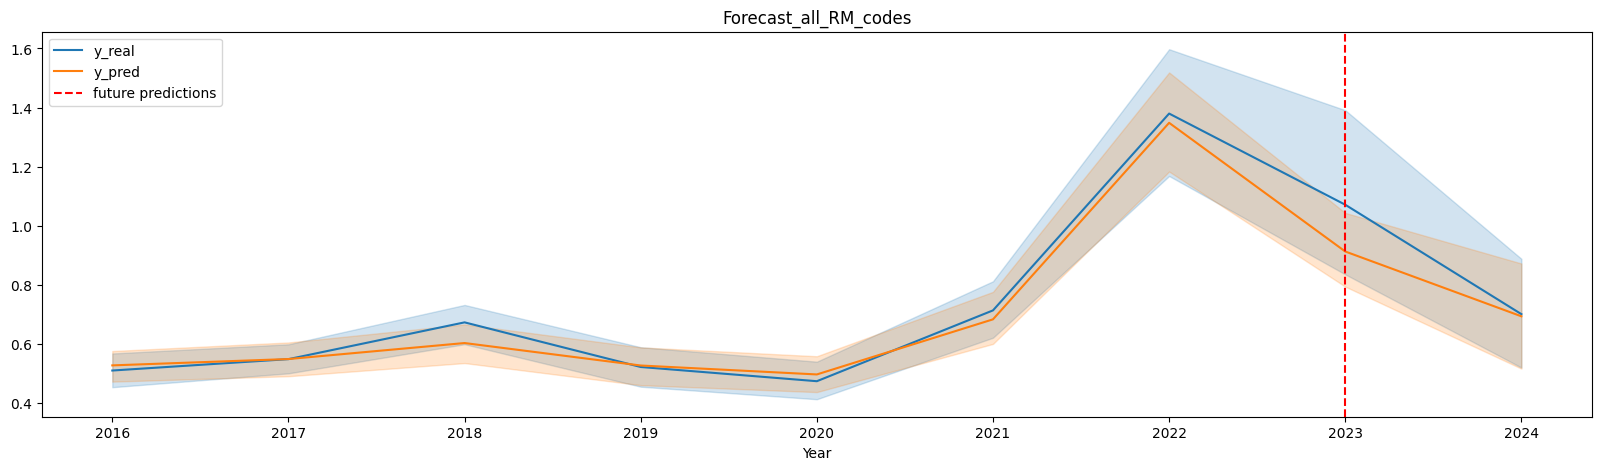

In [20]:
## Visualisation - all Key RM codes
fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=acid_df_24, x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=acid_df_24, x='Year', y=y_pred_24_inverse, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_all_RM_codes', ylabel='');

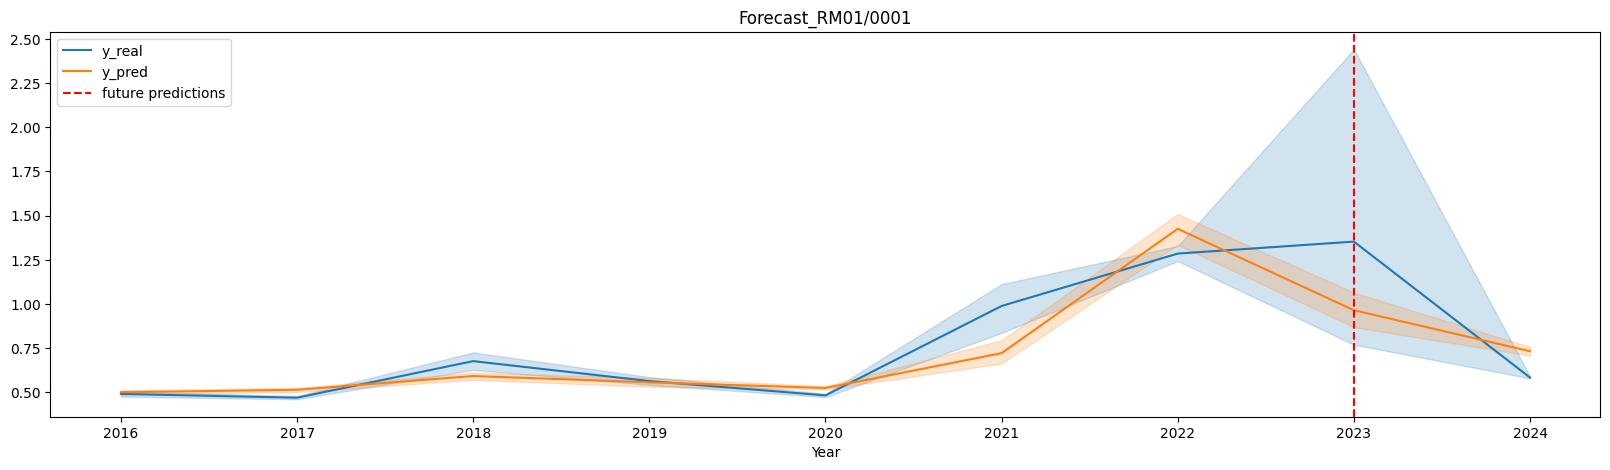

In [21]:
## Visualisation - individual Key RM codes
# Visualisation for RM01/0001
filter = ((acid_df_24['RM01/0004'] == 0) &\
          (acid_df_24['RM01/0006'] == 0) &\
          (acid_df_24['RM01/0007'] == 0))

X_24_01 = feature_list[filter].values
y_24_01 = acid_df_24[filter]['Average_price'].values

X_scaled_24_01 = scaler_x.transform(X_24_01)

y_pred_24_01 = best_lasso_model.predict(X_scaled_24_01)
y_pred_24_inverse_01 = np.exp(scaler_y.inverse_transform(y_pred_24_01.reshape(-1,1))).reshape(-1)


fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=acid_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=acid_df_24[filter], x='Year', y=y_pred_24_inverse_01, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_RM01/0001', ylabel='');

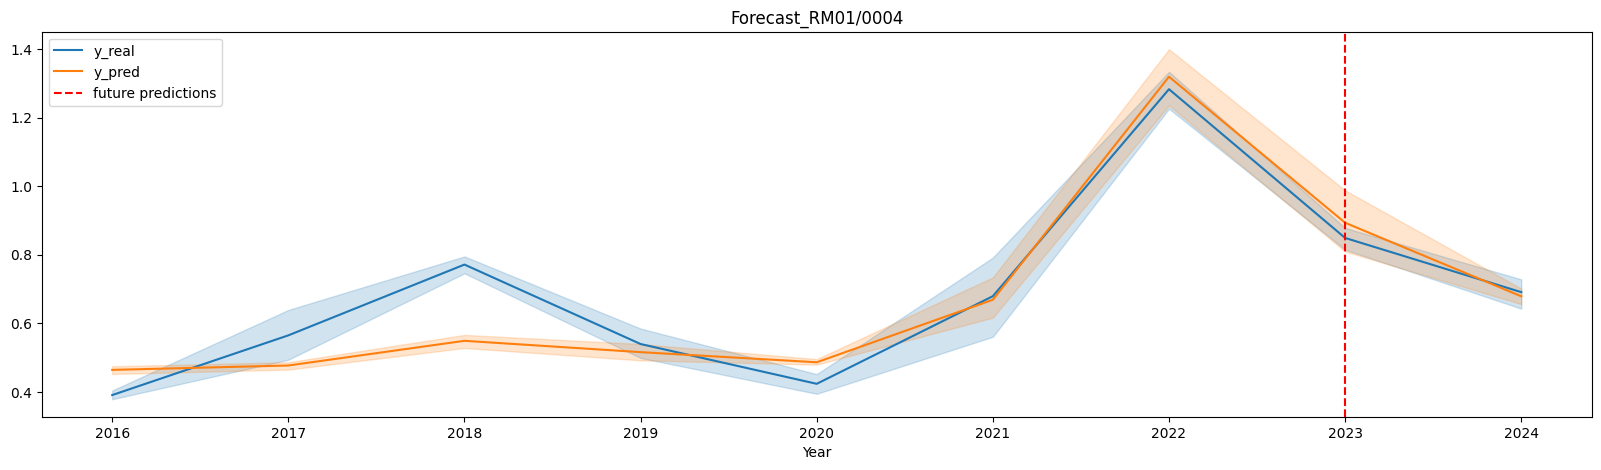

In [22]:
## Visualisation - individual Key RM codes
# Visualisation for RM01/0004
filter = ((acid_df_24['RM01/0004'] == 1) &\
          (acid_df_24['RM01/0006'] == 0) &\
          (acid_df_24['RM01/0007'] == 0))

X_24_01 = feature_list[filter].values
y_24_01 = acid_df_24[filter]['Average_price'].values

X_scaled_24_01 = scaler_x.transform(X_24_01)

y_pred_24_01 = best_lasso_model.predict(X_scaled_24_01)
y_pred_24_inverse_01 = np.exp(scaler_y.inverse_transform(y_pred_24_01.reshape(-1,1))).reshape(-1)


fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=acid_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=acid_df_24[filter], x='Year', y=y_pred_24_inverse_01, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_RM01/0004', ylabel='');

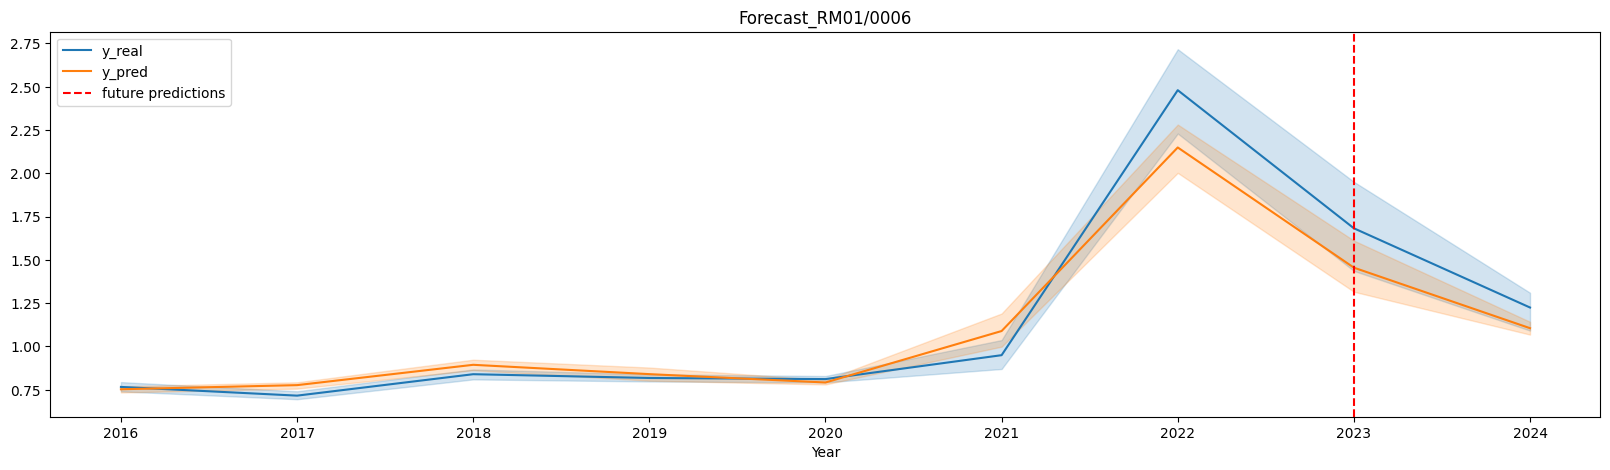

In [23]:
## Visualisation - individual Key RM codes
# Visualisation for RM01/0006
filter = ((acid_df_24['RM01/0004'] == 0) &\
          (acid_df_24['RM01/0006'] == 1) &\
          (acid_df_24['RM01/0007'] == 0))

X_24_01 = feature_list[filter].values
y_24_01 = acid_df_24[filter]['Average_price'].values

X_scaled_24_01 = scaler_x.transform(X_24_01)

y_pred_24_01 = best_lasso_model.predict(X_scaled_24_01)
y_pred_24_inverse_01 = np.exp(scaler_y.inverse_transform(y_pred_24_01.reshape(-1,1))).reshape(-1)


fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=acid_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=acid_df_24[filter], x='Year', y=y_pred_24_inverse_01, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_RM01/0006', ylabel='');

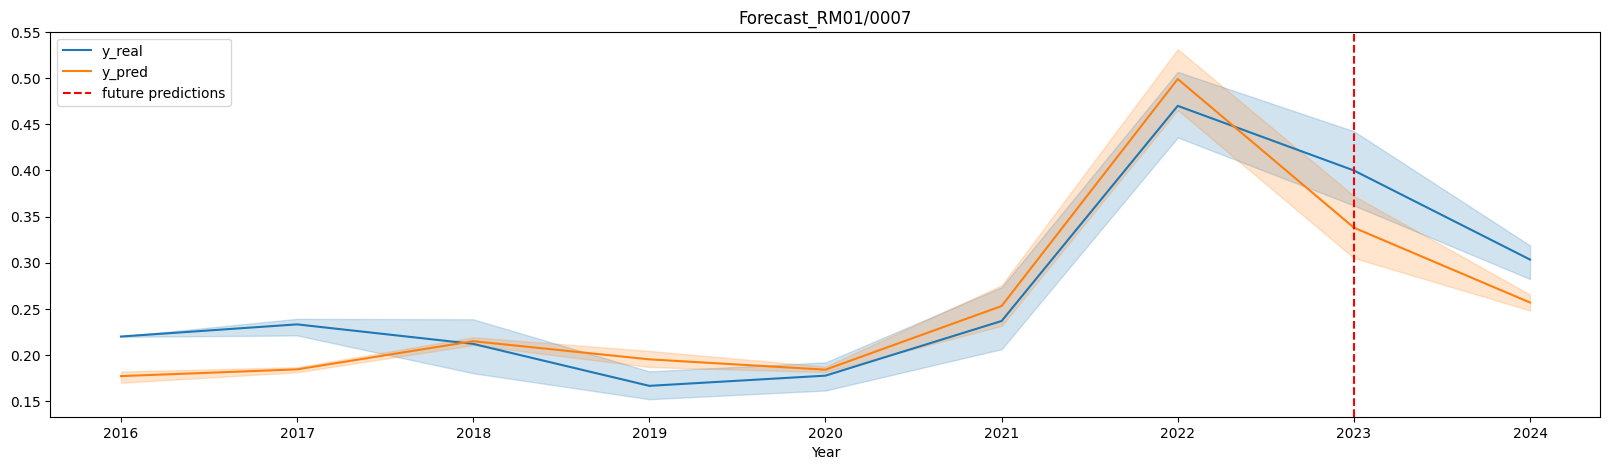

In [24]:
## Visualisation - individual Key RM codes
# Visualisation for RM01/0007
filter = ((acid_df_24['RM01/0004'] == 0) &\
          (acid_df_24['RM01/0006'] == 0) &\
          (acid_df_24['RM01/0007'] == 1))

X_24_01 = feature_list[filter].values
y_24_01 = acid_df_24[filter]['Average_price'].values

X_scaled_24_01 = scaler_x.transform(X_24_01)

y_pred_24_01 = best_lasso_model.predict(X_scaled_24_01)
y_pred_24_inverse_01 = np.exp(scaler_y.inverse_transform(y_pred_24_01.reshape(-1,1))).reshape(-1)


fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=acid_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=acid_df_24[filter], x='Year', y=y_pred_24_inverse_01, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast_RM01/0007', ylabel='');